### 对抗样本

测试 **对抗样本** 相关的算法, 本代码主要是按照 李宏毅 2023ml 的 hw10 进行测试改变的。

其使用的 [pytorchcv](https://github.com/osmr/imgclsmob) 库已经较长时间没有更新了, 而最近 pytorch 又升级到了 2+ 的版本, 后续可能会有适配问题。

reference:

+ https://colab.research.google.com/drive/1GmZI-58gQXxu6VTYHGpf0Ob1iZ8PB4GV 
+ https://speech.ee.ntu.edu.tw/~hylee/ml/ml2023-course-data/HW10.pdf 


In [1]:
import torch 
from torch import Tensor, nn
from torch.nn import functional as F 

from tqdm import tqdm

device = torch.device("cuda:0")

In [2]:
# 数据集下载: https://www.dropbox.com/s/lbpypqamqjpt2qz/data.zip
# 解压后将文件夹名字改成 fgsm_test
# 使用的是 cifar-10 数据集

CIFAR10_MEAN = (0.491, 0.482, 0.447)  # cifar10 数据集的均值
CIFAR10_STD = (0.202, 0.199, 0.201)  # cifar10 数据集的标准差

from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder


dataset = ImageFolder(
    root="fgsm_test",
    transform=transforms.Compose([
        # pixel 的取值范围从 0-255 变成 0-1
        transforms.ToTensor(),
        # pixel 值减去均值除以方差, 取值范围是实数域, 并且在其对应的 channel 中的均值是 0, 方差是 1
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
    ])
)

In [3]:
from pytorchcv.model_provider import get_model as ptcv_get_model  # type: ignore

# 可以从 https://github.com/osmr/imgclsmob/releases/download/v0.0.163/resnet110_cifar10-0369-4d6ca1fc.pth.zip 中下载模型到 ~/.torch/models 中
model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device).eval()

In [24]:
mean = torch.tensor(CIFAR10_MEAN).to(device)[:, None, None]
std = torch.tensor(CIFAR10_STD).to(device)[:, None, None]

# epsilon 要设置成人眼观察不到的扰动, 这里认为一个 pixel 最多增加或者减少 8 个强度
epsilon = 8 / 255 / std

In [99]:
from torch.utils.data import DataLoader


def evaluate(data_loader, attack_func = None, output_result: bool = True):

    correct_number, total_loss = 0.0, 0.0

    for batch_images, y_true in tqdm(data_loader, disable=True):

        batch_images, y_true = batch_images.to(device), y_true.to(device)
        
        if attack_func is not None:
            batch_images = attack_func(batch_images, y_true)
            
            batch_images = (batch_images * std + mean).clamp(0, 1)
            batch_images = torch.round((batch_images * 255)).clamp(0, 255)
            
            batch_images = (batch_images / 255 - mean) / std

        with torch.no_grad():
            logits = model(batch_images)
        y_pred = logits.argmax(dim=1)

        total_loss += F.cross_entropy(logits, y_true, reduction="sum").item()
        correct_number += (y_true == y_pred).sum().item()

    accuracy = correct_number / len(data_loader.dataset)
    avg_loss = total_loss / len(data_loader.dataset)
    
    if output_result:
        print()
        print(f"正确率是: {round(accuracy * 100, 2)}%")
        print(f"平均损失值是: {round(avg_loss, 5)}")
    
    # return accuracy, avg_loss


dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

evaluate(dataloader)  # 两个标签的编号居然对上了 ...


正确率是: 95.0%
平均损失值是: 0.22677


### FGSM

FGSM 全称是 Fast Gradient Sign Method, 出自 谷歌 2014 年 论文 [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)。

这里实现的是 non-targeted 方法, 只要求预测错误, 因此 loss 值加个负号即可。整个方案不更新模型参数, 只更新 image 部分的参数。同时我们寻找的也不是全局的噪声, 而是一张图片一个噪声, 因此一次迭代就能取得比较好的效果。


In [100]:
def fgsm(batch_images, y_true):
    
    new_batch_images: Tensor = batch_images.detach().clone()
    new_batch_images.requires_grad = True

    obj_value = - F.cross_entropy(model(new_batch_images), y_true)
    obj_value.backward()
    
    grad = new_batch_images.grad.detach()
    
    return batch_images - epsilon * grad.sign()


evaluate(dataloader, fgsm)


正确率是: 59.0%
平均损失值是: 2.48211


### Iterative FGSM

出自 谷歌大脑 和 OpenAI 2016 年论文 [Adversarial examples in the physical world](https://arxiv.org/abs/1607.02533) 的 2.2 节。

In [101]:
alpha = 0.8 / 255 / std 
num_iters = 20


def iter_fgsm(batch_images, y_true):
    
    new_batch_images = batch_images.clone()
    
    for _ in range(num_iters):
        
        new_batch_images.requires_grad = True
        obj_value = - F.cross_entropy(model(new_batch_images), y_true)
        obj_value.backward()
        
        grad = new_batch_images.grad.detach()
        new_batch_images = new_batch_images.detach() - alpha * grad.sign()
        
        new_batch_images = torch.clamp(new_batch_images, min=batch_images - epsilon, max=batch_images + epsilon)
    
    return new_batch_images
        

evaluate(dataloader, iter_fgsm)


正确率是: 0.5%
平均损失值是: 17.36643


### Momentum Iterative FGSM

出自 2017 年清华大学的论文: [Boosting Adversarial Attacks with Momentum](https://arxiv.org/abs/1710.06081)

In [107]:
alpha = 0.8 / 255 / std 
num_iters = 20
decay = 0.3


def momentum_fgsm(batch_images, y_true):
    
    new_batch_images = batch_images.clone()
    
    grad = torch.zeros_like(new_batch_images)
    
    for _ in range(num_iters):
        new_batch_images.requires_grad = True
        obj_value = - F.cross_entropy(model(new_batch_images), y_true)
        obj_value.backward()
        
        new_grad = new_batch_images.grad.detach()
        
        grad = decay * grad + new_grad / torch.norm(new_grad, p=1) # dim=1, keepdim=True)
        new_batch_images = new_batch_images.detach() - alpha * grad.sign()
        
        new_batch_images = torch.clamp(new_batch_images, min=batch_images - epsilon, max=batch_images + epsilon)
    
    return new_batch_images
        

evaluate(dataloader, momentum_fgsm)


正确率是: 0.5%
平均损失值是: 18.28609


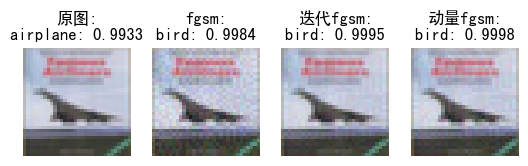

In [124]:
import matplotlib.pyplot as plt 


def recover_image(image: Tensor):
    
    image = (image * std + mean).clamp(0, 1)
    image = torch.round((image * 255)).clamp(0, 255)
    image = image.permute(1, 2, 0)
    image = image.detach().cpu().numpy().astype("uint8")
    
    return image 


def get_model_info(image: Tensor):
    with torch.no_grad():
        logits = model(image.unsqueeze(0))[0]
    
    probs = torch.softmax(logits, dim=0)
    y_pred = logits.argmax().item()
    
    return f"{dataset.classes[y_pred]}: {round(probs[y_pred].item(), 4)}"

test_image, test_label = dataset[0]

test_image = test_image.to(device)
y_true = torch.LongTensor([test_label, ]).to(device)

plt.subplot(1, 4, 1)
plt.title("原图:\n" + get_model_info(test_image))
plt.imshow(recover_image(test_image))
plt.axis("off")

plt.subplot(1, 4, 2)
fgsm_image = fgsm(test_image[None, ...], y_true)[0]
plt.title("fgsm:\n" + get_model_info(fgsm_image))
plt.imshow(recover_image(fgsm_image))
plt.axis("off")

plt.subplot(1, 4, 3)
iter_fgsm_image = iter_fgsm(test_image[None, ...], y_true)[0]
plt.title("迭代fgsm:\n" + get_model_info(iter_fgsm_image))
plt.imshow(recover_image(iter_fgsm_image))
plt.axis("off")

plt.subplot(1, 4, 4)
momentum_fgsm_image = momentum_fgsm(test_image[None, ...], y_true)[0]
plt.title("动量fgsm:\n" + get_model_info(momentum_fgsm_image))
plt.imshow(recover_image(momentum_fgsm_image))
plt.axis("off")

plt.show()